# Plant Disease Detection Model
This notebook creates a CNN model to classify plant diseases from images.
Dataset: 38 classes of plant diseases with ~70,000 training images

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
# Dataset paths
base_path = '../dataset/Plant Diseases Dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')

# Model parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 38

In [3]:
# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
valid_generator = valid_datagen.flow_from_directory(
    valid_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {valid_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Training samples: 70295
Validation samples: 17572
Number of classes: 38


In [4]:
# Display class names
class_names = list(train_generator.class_indices.keys())
print("Disease Classes:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

Disease Classes:
0: Apple___Apple_scab
1: Apple___Black_rot
2: Apple___Cedar_apple_rust
3: Apple___healthy
4: Blueberry___healthy
5: Cherry_(including_sour)___Powdery_mildew
6: Cherry_(including_sour)___healthy
7: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
8: Corn_(maize)___Common_rust_
9: Corn_(maize)___Northern_Leaf_Blight
10: Corn_(maize)___healthy
11: Grape___Black_rot
12: Grape___Esca_(Black_Measles)
13: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
14: Grape___healthy
15: Orange___Haunglongbing_(Citrus_greening)
16: Peach___Bacterial_spot
17: Peach___healthy
18: Pepper,_bell___Bacterial_spot
19: Pepper,_bell___healthy
20: Potato___Early_blight
21: Potato___Late_blight
22: Potato___healthy
23: Raspberry___healthy
24: Soybean___healthy
25: Squash___Powdery_mildew
26: Strawberry___Leaf_scorch
27: Strawberry___healthy
28: Tomato___Bacterial_spot
29: Tomato___Early_blight
30: Tomato___Late_blight
31: Tomato___Leaf_Mold
32: Tomato___Septoria_leaf_spot
33: Tomato___Spider_mites Two

In [5]:
# Create CNN model with transfer learning (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │        19,494 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,933,350 (11.19 MB)

 Trainable params: 675,366 (2.58 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
# Callbacks for training
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-7
    )
]

In [7]:
# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=callbacks,
    verbose=1
)

/Users/debabratapattnayak/project-ml/.venv/lib/python3.13/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 673s 305ms/step - accuracy: 0.7290 - loss: 0.8748 - val_accuracy: 0.8842 - val_loss: 0.3595 - learning_rate: 0.0010
Epoch 2/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 744s 338ms/step - accuracy: 0.8034 - loss: 0.6077 - val_accuracy: 0.9050 - val_loss: 0.2948 - learning_rate: 0.0010
Epoch 3/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 759s 345ms/step - accuracy: 0.8184 - loss: 0.5635 - val_accuracy: 0.8958 - val_loss: 0.3082 - learning_rate: 0.0010
Epoch 4/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 757s 344ms/step - accuracy: 0.8267 - loss: 0.5424 - val_accuracy: 0.9022 - val_loss: 0.2898 - learning_rate: 0.0010
Epoch 5/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 780s 355ms/step - accuracy: 0.8311 - loss: 0.5296 - val_accuracy: 0.9073 - val_loss: 0.2764 - learning_rate: 0.0010
Epoch 6/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 770s 350ms/step - accuracy: 0.8370 - loss: 0.5101 - val_accuracy: 0.9093 - val_loss: 0.2678 - learning_rate: 0.0010
Epoch 7/20
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 768s 349ms

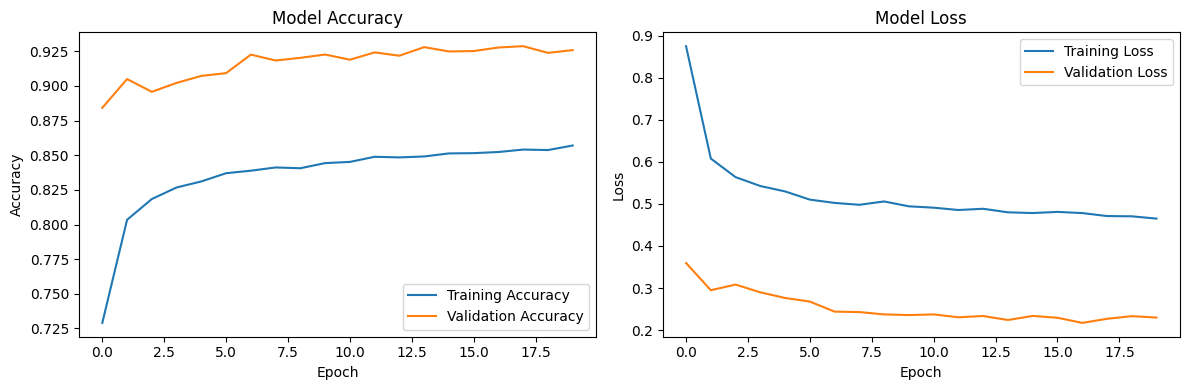

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Fine-tuning: Unfreeze top layers of base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Use lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Fine-tuning from layer {fine_tune_at}")

Fine-tuning from layer 100


In [10]:
# Fine-tune the model
fine_tune_epochs = 10
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=valid_generator,
    callbacks=callbacks,
    verbose=1
)

Epoch 20/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1110s 503ms/step - accuracy: 0.7272 - loss: 1.1856 - val_accuracy: 0.9178 - val_loss: 0.2522 - learning_rate: 1.0000e-05
Epoch 21/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1057s 481ms/step - accuracy: 0.8541 - loss: 0.4880 - val_accuracy: 0.9367 - val_loss: 0.1957 - learning_rate: 1.0000e-05
Epoch 22/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1085s 493ms/step - accuracy: 0.8896 - loss: 0.3564 - val_accuracy: 0.9523 - val_loss: 0.1503 - learning_rate: 1.0000e-05
Epoch 23/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1082s 493ms/step - accuracy: 0.9083 - loss: 0.2895 - val_accuracy: 0.9574 - val_loss: 0.1300 - learning_rate: 1.0000e-05
Epoch 24/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1059s 482ms/step - accuracy: 0.9205 - loss: 0.2508 - val_accuracy: 0.9641 - val_loss: 0.1103 - learning_rate: 1.0000e-05
Epoch 25/30
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 1080s 492ms/step - accuracy: 0.9327 - loss: 0.2082 - val_accuracy: 0.9671 - val_loss: 0.0999 - learning_rate: 1.0000e-05
Epoch 26/30
2197

In [11]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(valid_generator, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

Final Test Accuracy: 0.9768
Final Test Loss: 0.0692


In [12]:
# Generate predictions for classification report
valid_generator.reset()
predictions = model.predict(valid_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = valid_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))

550/550 ━━━━━━━━━━━━━━━━━━━━ 130s 236ms/step
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98       504
                                 Apple___Black_rot       0.98      1.00      0.99       497
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       440
                                   Apple___healthy       0.99      0.99      0.99       502
                               Blueberry___healthy       0.99      0.99      0.99       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.96      0.90      0.93       410
                       Corn_(maize)___Common_rust_       0.99      1.00      0.99       477
           

In [13]:
# Save the model and class names
model_path = '../models/plant_disease_model.h5'
class_names_path = '../models/plant_disease_classes.pkl'

model.save(model_path)
joblib.dump(class_names, class_names_path)

print(f"Model saved to: {model_path}")
print(f"Class names saved to: {class_names_path}")

Model saved to: ../models/plant_disease_model.h5
Class names saved to: ../models/plant_disease_classes.pkl


In [14]:
# Create prediction function
def predict_disease(image_path, model, class_names):
    """
    Predict plant disease from image
    """
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    predicted_class = class_names[predicted_class_idx]
    
    return predicted_class, confidence

# Save prediction function
prediction_code = '''
import tensorflow as tf
import numpy as np
import joblib
from tensorflow.keras.preprocessing import image

def load_plant_disease_model():
    """Load the trained plant disease detection model"""
    model = tf.keras.models.load_model('../models/plant_disease_model.h5')
    class_names = joblib.load('../models/plant_disease_classes.pkl')
    return model, class_names

def predict_plant_disease(image_path):
    """Predict plant disease from image path"""
    model, class_names = load_plant_disease_model()
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make prediction
    predictions = model.predict(img_array)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    predicted_class = class_names[predicted_class_idx]
    
    return {
        "disease": predicted_class,
        "confidence": float(confidence),
        "all_predictions": {class_names[i]: float(predictions[0][i]) for i in range(len(class_names))}
    }
'''

with open('../models/plant_disease_predictor.py', 'w') as f:
    f.write(prediction_code)

print("Prediction utility saved to: ../models/plant_disease_predictor.py")

Prediction utility saved to: ../models/plant_disease_predictor.py


In [15]:
# Test prediction on sample images
test_images_path = '../dataset/Plant Diseases Dataset/test/test'
test_images = os.listdir(test_images_path)[:5]  # Test first 5 images

print("Testing predictions on sample images:")
for img_name in test_images:
    img_path = os.path.join(test_images_path, img_name)
    predicted_class, confidence = predict_disease(img_path, model, class_names)
    print(f"{img_name}: {predicted_class} (Confidence: {confidence:.3f})")

Testing predictions on sample images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
AppleScab3.JPG: Apple___Apple_scab (Confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
TomatoEarlyBlight2.JPG: Tomato___Early_blight (Confidence: 0.457)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
TomatoEarlyBlight3.JPG: Tomato___Target_Spot (Confidence: 0.422)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
PotatoHealthy1.JPG: Potato___healthy (Confidence: 1.000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
AppleScab2.JPG: Apple___Apple_scab (Confidence: 1.000)


In [16]:
# Model summary and performance metrics
print("\n=== PLANT DISEASE DETECTION MODEL SUMMARY ===")
print(f"Model Architecture: MobileNetV2 + Custom Classifier")
print(f"Input Size: {IMG_SIZE}x{IMG_SIZE}x3")
print(f"Number of Classes: {NUM_CLASSES}")
print(f"Training Samples: {train_generator.samples}")
print(f"Validation Samples: {valid_generator.samples}")
print(f"Final Accuracy: {test_accuracy:.4f}")
print(f"Model Size: {os.path.getsize(model_path) / (1024*1024):.1f} MB")
print(f"\nModel saved at: {model_path}")
print(f"Classes saved at: {class_names_path}")
print(f"Predictor utility: ../models/plant_disease_predictor.py")


=== PLANT DISEASE DETECTION MODEL SUMMARY ===
Model Architecture: MobileNetV2 + Custom Classifier
Input Size: 224x224x3
Number of Classes: 38
Training Samples: 70295
Validation Samples: 17572
Final Accuracy: 0.9768
Model Size: 30.9 MB

Model saved at: ../models/plant_disease_model.h5
Classes saved at: ../models/plant_disease_classes.pkl
Predictor utility: ../models/plant_disease_predictor.py
